# Convolutional Neural Networks — Classification of Waste Images with Keras

### Installing the livelossplot library

In [ ]:
! pip install livelossplot

### Importing the necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
from sklearn.metrics import precision_recall_fscore_support, accuracy_score



### Downloading and Extracting the dataset

In [ ]:
! wget https://archive.ics.uci.edu/static/public/908/realwaste.zip

--2024-03-10 02:40:48--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [          <=>       ] 656.65M  13.5MB/s    in 64s     

2024-03-10 02:41:52 (10.3 MB/s) - ‘realwaste.zip’ saved [688545323]



In [ ]:
!unzip realwaste.zip

### Defining a function to split the dataset folder into training and testing directories

In [ ]:
def split_dataset(root_folder):
    # Setting the root directory path
    root_dir = os.path.join(root_folder, 'realwaste-main')

    # Setting the destination directories for training and testing data
    train_dir = os.path.join(root_dir, 'training_data')
    test_dir = os.path.join(root_dir, 'testing_data')

    # Setting the split ratio (0.75 for training, 0.25 for testing)
    split_ratio = 0.75

    # Creating the destination directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Iterating through each waste class directory in the root directory
    waste_classes = os.listdir(os.path.join(root_dir, 'RealWaste'))
    for waste_class in waste_classes:
        class_dir = os.path.join(root_dir, 'RealWaste', waste_class)

        # Creating corresponding directories in the training and testing data directories
        train_class_dir = os.path.join(train_dir, waste_class)
        test_class_dir = os.path.join(test_dir, waste_class)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Getting the list of image files in the current waste class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

        # Calculating the split point based on the split ratio
        split_point = int(len(image_files) * split_ratio)

        # Shuffling the image files randomly
        random.shuffle(image_files)

        # Moving the images to the training or testing directories based on the split point
        for i, image_file in enumerate(image_files):
            src_path = os.path.join(class_dir, image_file)
            if i < split_point:
                dst_path = os.path.join(train_class_dir, image_file)
            else:
                dst_path = os.path.join(test_class_dir, image_file)
            shutil.copy(src_path, dst_path)

    print('Dataset was successfully splitted into train and test.')

In [ ]:
download_dir = Path('/content')
split_dataset(download_dir)

Dataset was successfully splitted into train and test.


After splitting, our data has the following folder structure:
* realwaste-main (root directory)
* ->Realwaste (directory inside the root one)
* -> testing_data (25% of all images)
** ---->Cardboard (directory containing .jpg waste images)
** ---->Food Organics (directory containing .jpg waste images)
** ----> more image directories ( 9 in total)
* -> training_data (75 % of all images)
** ---->Cardboard (directory containing .jpg waste images)
** ---->Food Organics (directory containing .jpg waste images)
** ----> more image directories ( 9 in total)

### Data Normalization and Augmentation



It is important for the pixel values to be in the range 0 to 1. To reach this goal, we divide all of them by 255. Data augmentation is a key step as well. It helps bring variety in our dataset by making the model see images under different viewpoints and angles, thus bulding view invariance.

In [ ]:
# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

In [ ]:
# Generating an image generator for the training set and applying preprocessing operations
train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [ ]:
# The different food classes in our dataset
class_subset = sorted(os.listdir('/content/realwaste-main/training_data'))
class_subset

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

### Preparing the data for training

In [ ]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'realwaste-main/training_data',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'realwaste-main/testing_data',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 3031 images belonging to 9 classes.
Found 174 images belonging to 9 classes.


### Building the model

In [ ]:
model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

### Training the model

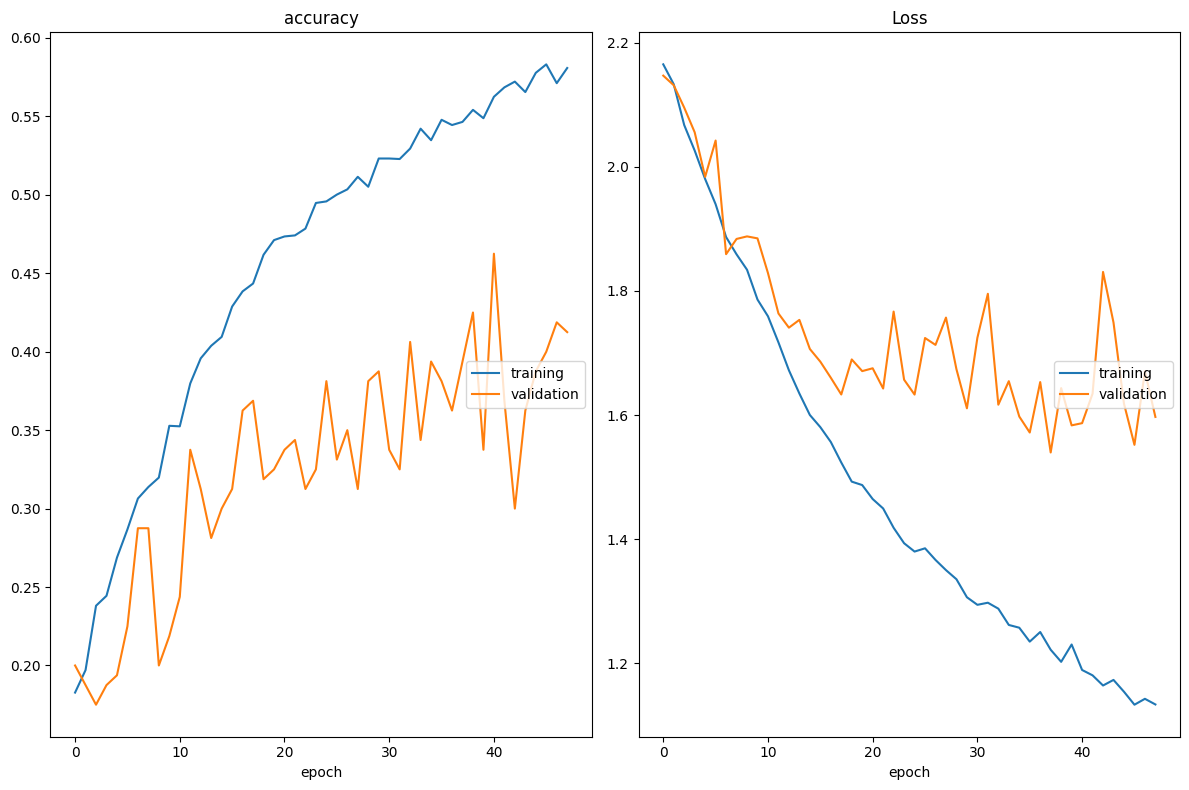

accuracy
	training         	 (min:    0.183, max:    0.583, cur:    0.581)
	validation       	 (min:    0.175, max:    0.463, cur:    0.412)
Loss
	training         	 (min:    1.133, max:    2.165, cur:    1.134)
	validation       	 (min:    1.540, max:    2.147, cur:    1.597)
CPU times: user 26min 53s, sys: 26.8 s, total: 27min 20s
Wall time: 28min 49s


In [ ]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='model.hdf5',
                               verbose=1,
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

We can see that the early stopping regularization is effectively implemented, because the training is stopped just as the validation accuracy (resp. loss) is about to decrease (resp. increase).

At the end of the 50 epochs of the training phase, the model reaches a maximum accuracy of 58.1%, which is poor. An accuracy score this close to 50 % means that the model is almost as good as a random classifier, which would be expected to be wrong half of the time. It is therefore not a good model that we have here. But its fine-tuning would be a strenuous task and is out of the scope of this work.

The complexity of our network along with the size of the dataset make the training quite computationally expensive. Even with the colab T4 GPU, the training phase took about 28 min.

### Model Evaluation

Our model shall be evaluated on accuracy, precision, recall, and f1 score, computed using the functions defined in sklearn.metrics

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'realwaste-main/testing_data',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

Found 1191 images belonging to 9 classes.


In [ ]:
model.load_weights('model.hdf5') # Loading the weights of the previously trained model

predicted_classes = model.predict(testgen) # Returns an array of values among which the index of greatest one is the
                                           # model's prediction
predictions = np.array([np.argmax(x) for x in predicted_classes]) # Extracting the predictions as a array of numbers (0-9)
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
# Convert class_indices dictionary to have tuples as keys
true_classes = testgen.classes

1191/1191 [==============================] - 83s 70ms/step


Due to the long time it took to train the model, we saved the optimal weights in a file to access them directly later on without having to rerun the code.

### Defining functions to display the classification results in the form of an array (pandas data frame) and the images along with the predicted class/corrected class pairs

In [ ]:
def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    # Here, we reandomly pick 20 samples from the test set without replacement. And for each sample (image), we
    # display the correct and predicted class in green if they match and in red if they don't
    for i, idx in enumerate(np.random.choice(testgen.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(testgen[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

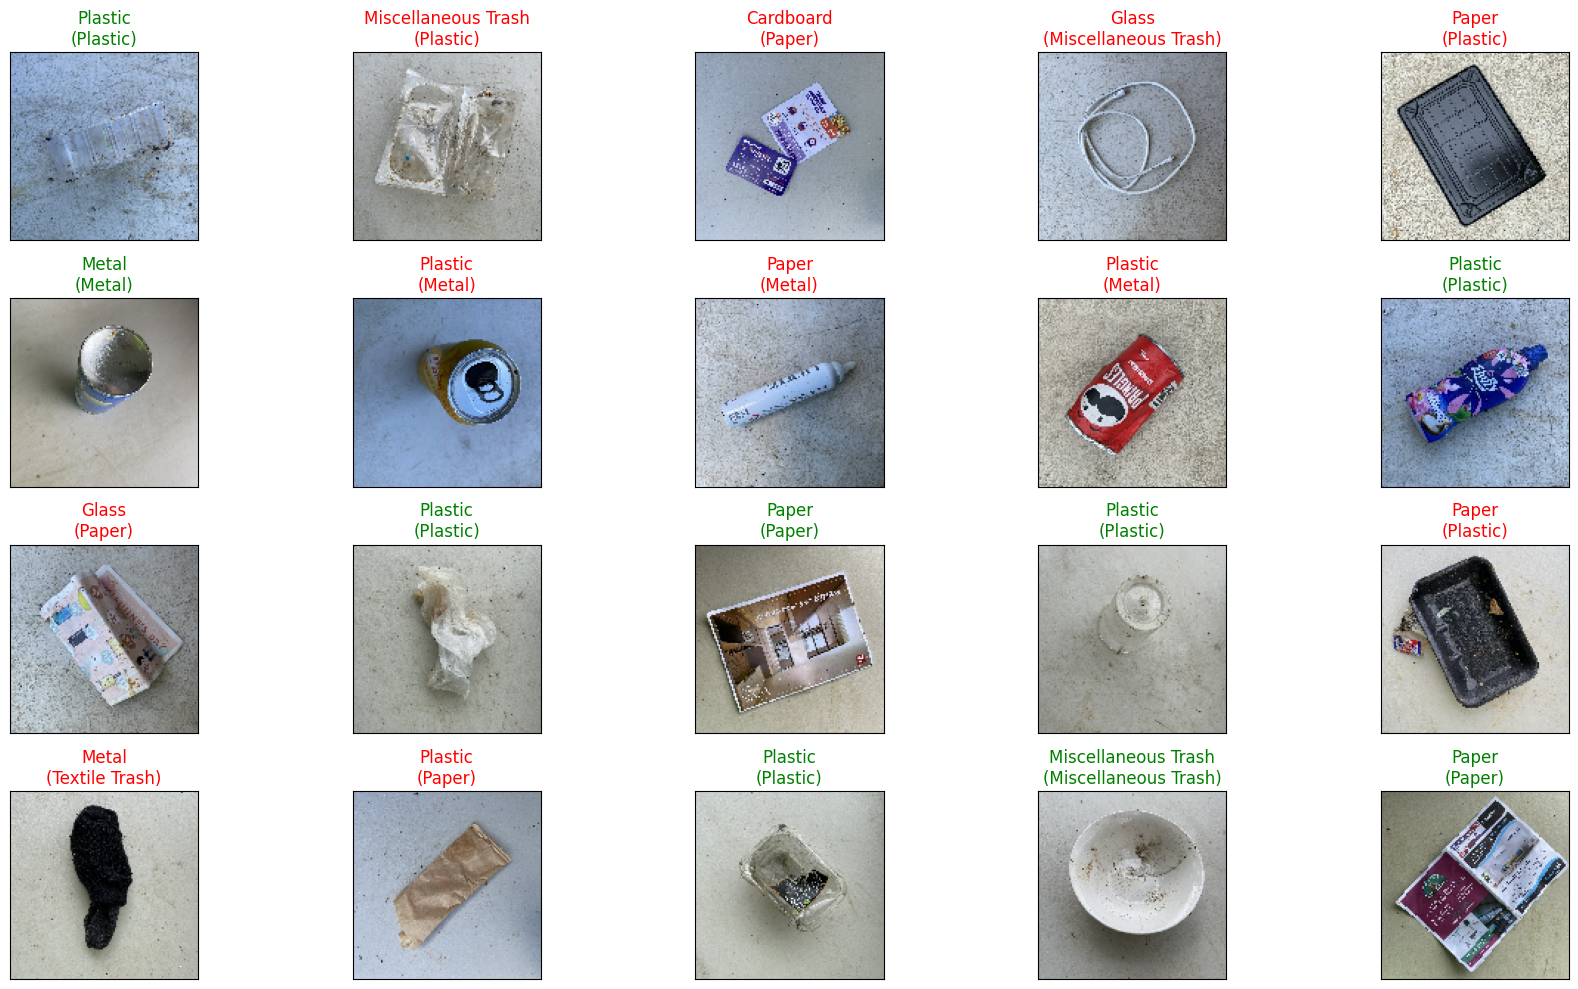

In [ ]:
plot_predictions(true_classes, predictions, testgen, class_indices)

As we can see, the model is able to correctly classify some images of food but still makes a lot of mistakes. Recall that the accuracy on the training set was just 58.1%. Let's see how the model performs on the unseen test data.

In [ ]:
display_results(true_classes, predictions, class_indices.values())

Overall Categorical Accuracy: 51.81%


,Precision,Recall,F-Score,Support
Vegetation,0.736434,0.871560,0.798319,109.0
Cardboard,0.680000,0.586207,0.629630,116.0
Glass,0.570248,0.657143,0.610619,105.0
Food Organics,0.602041,0.572816,0.587065,103.0
Plastic,0.410448,0.714286,0.521327,231.0
Paper,0.472868,0.488000,0.480315,125.0
Metal,0.597938,0.292929,0.393220,198.0
Miscellaneous Trash,0.359223,0.298387,0.325991,124.0
Textile Trash,0.416667,0.062500,0.108696,80.0


We can see that the model is quite good with a few classes (e.g. Vegetation and Cardboard, respectively 73.6% and 68% precision) and quite bad on some others (plastic, paper,miscellaneous trash, respectively 41%, 47% and 35% precision, which is worse than a random classifier). Overall, its accuracy is 51.81%, slightly less than what was achieved on the training set.